In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

#import tensorflow as tf
#tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
#logger.info('Using tensorflow : {}'.format(tf.__version__))
#logger.info('Using keras      : {}'.format(tf.keras.__version__))
#logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2
[INFO    ] Using emtf-nnet  : 0.0.2-dev


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 200_000
#maxevents = -1

# Input files
signal_fname = 'signal.210922.npz'
signal_dxy_fname = 'signal_dxy.210922.npz'
bkgnd_fname = 'bkgnd.210922.npz'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 200000


### Load data

In [4]:
def load_signal(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
  logger.info('out_part: {}, out_hits: {}, out_simhits: {}'.format(
      (out_part.shape, out_part.dtype.name),
      (out_hits_shape, out_hits_values.dtype.name),
      (out_simhits_shape, out_simhits_values.dtype.name)))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    bkg_aux = loaded['out_aux']
    bkg_hits_values = loaded['out_hits_values']
    bkg_hits_row_splits = loaded['out_hits_row_splits']
    bkg_hits_shape = (bkg_hits_row_splits.shape[0] - 1,) + (None,) + bkg_hits_values.shape[1:]
  logger.info('bkg_aux: {} bkg_hits: {}'.format(
      (bkg_aux.shape, bkg_aux.dtype.name),
      (bkg_hits_shape, bkg_hits_values.dtype.name)))
  return (bkg_aux, (bkg_hits_values, bkg_hits_row_splits))

In [5]:
# Load data
out_part, out_hits, out_simhits = load_signal(signal_fname)

[INFO    ] Loading from signal.210922.npz
[INFO    ] out_part: ((2000000, 10), 'float32'), out_hits: ((2000000, None, 17), 'int32'), out_simhits: ((2000000, None, 17), 'int32')


In [6]:
# particle info
_part_fields = [
  'part_invpt',
  'part_eta',
  'part_phi',
  'part_vx',
  'part_vy',
  'part_vz',
  'part_d0',
  'part_bx',
  'part_sector',
  'part_zone',
]
PartFields = collections.namedtuple('PartFields', _part_fields)
part_fields = PartFields(*range(len(_part_fields)))

# sector_hits info
_sector_hits_fields = [
  'emtf_chamber',
  'emtf_segment',
  'emtf_phi',
  'emtf_bend',
  'emtf_theta1',
  'emtf_theta2',
  'emtf_qual1',
  'emtf_qual2',
  'emtf_time',
  'zones',
  'timezones',
  'cscfr',
  'gemdl',
  'bx',
  'emtf_site',
  'emtf_host',
  'valid',
]
SectorHitsFields = collections.namedtuple('SectorHitsFields', _sector_hits_fields)
sector_hits_fields = SectorHitsFields(*range(len(_sector_hits_fields)))

In [7]:
# Build a container of particle info and sector hits info
class SectorHits(object):
  def __init__(self, part, sector_hits, num_samples=None):
    RaggedTensorValue = emtf_nnet.ragged.RaggedTensorValue
    self._part = part
    self._sector_hits = RaggedTensorValue(values=sector_hits[0], row_splits=sector_hits[1])
    assert len(self._part) == len(self._sector_hits)
    assert self._part.shape[-1] == len(part_fields)
    assert self._sector_hits.shape[-1] == len(sector_hits_fields)
    if num_samples is not None:
      self._part = self._part[:num_samples]
      self._sector_hits = self._sector_hits[:num_samples]

    # Convert to RaggedTensorValue
    part_values = np.zeros(
        self._sector_hits.values.shape[:-1] + (self._part.shape[-1],), dtype=self._part.dtype)
    part_row_splits = self._sector_hits.row_splits
    for i in range(self._sector_hits.nrows):
      part_values[part_row_splits[i]:part_row_splits[i + 1]] = self._part[i]
    self._part = RaggedTensorValue(values=part_values, row_splits=part_row_splits)

    # Set attributes
    for f in part_fields:
      setattr(self, part_fields._fields[f], self._part.values[:, f])
    for f in sector_hits_fields:
      setattr(self, sector_hits_fields._fields[f], self._sector_hits.values[:, f])

    # Set attributes (extra)
    with np.errstate(divide='ignore'):
      part_pt_values = np.reciprocal(np.abs(self.part_invpt))
      setattr(self, 'part_pt', part_pt_values)
    if not hasattr(self, 'emtf_theta'):
      setattr(self, 'emtf_theta', self.emtf_theta1)
    if not hasattr(self, 'emtf_qual'):
      setattr(self, 'emtf_qual', self.emtf_qual1)

  def __len__(self):
    return len(self._sector_hits)

  def __getitem__(self, item):
    return self._sector_hits[item]


sector_hits = SectorHits(out_part, out_hits, num_samples=maxevents)

sector_simhits = SectorHits(out_part, out_simhits, num_samples=maxevents)

part_pt_values = np.reciprocal(np.abs(out_part[:, part_fields.part_invpt]))

In [8]:
num_emtf_hosts = 19

emtf_host_labels = [
  'ME1/1', 'ME1/2', 'ME1/3', 'ME2/1', 'ME2/2', 'ME3/1', 'ME3/2', 'ME4/1', 'ME4/2',
  'GE1/1', 'RE1/2', 'RE1/3', 'GE2/1', 'RE2/2,3', 'RE3/1', 'RE3/2,3', 'RE4/1', 'RE4/2,3',
  'ME0',
]

### Make plots

In [9]:
class Plotter(object):
  def __init__(self, thres):
    self._thres = thres  # pt threshold
    assert self._thres >= 0.

    self._cache = np.empty(num_emtf_hosts, dtype=object)
    for k in range(num_emtf_hosts):
      self._cache[k] = []

  def _process(self):
    sel_thres = (part_pt_values > self._thres)

    for i in range(len(sector_hits)):
      if not sel_thres[i]:
        continue

      f1 = sector_hits_fields.emtf_host
      f2 = sector_hits_fields.emtf_phi

      d_sim = collections.defaultdict(list)
      arr = sector_simhits[i]
      for k, v in zip(arr[:, f1], arr[:, f2]):
        d_sim[k].append(v)

      d = collections.defaultdict(list)
      arr = sector_hits[i]
      for k, v in zip(arr[:, f1], arr[:, f2]):
        d[k].append(v)

      for k, v in d_sim.items():
        if k not in d:
          continue

        values_0 = v
        values_1 = d[k]
        x0 = np.random.choice(values_0)
        arg = np.argmin(np.abs([(x - x0) for x in values_1]))
        self._cache[k].append(values_1[arg] - x0)

    for k in range(num_emtf_hosts):
      self._cache[k] = np.asarray(self._cache[k], dtype=np.int32)

  def plot(self):
    self._process()

    fig, axs = plt.subplots(5, 4, figsize=(8, 8*5/4), tight_layout=True)
    for ij in range(num_emtf_hosts):
      i, j = (ij // 4, ij % 4)
      ax = axs[i, j]
      ax.hist(self._cache[ij], bins=60, range=(-60,60), color='C0', histtype='stepfilled', alpha=0.8)
      ax.text(0.68, 0.88, emtf_host_labels[ij], fontsize=9, transform=ax.transAxes)
      #ax.set_yscale('log')

    plt.show()

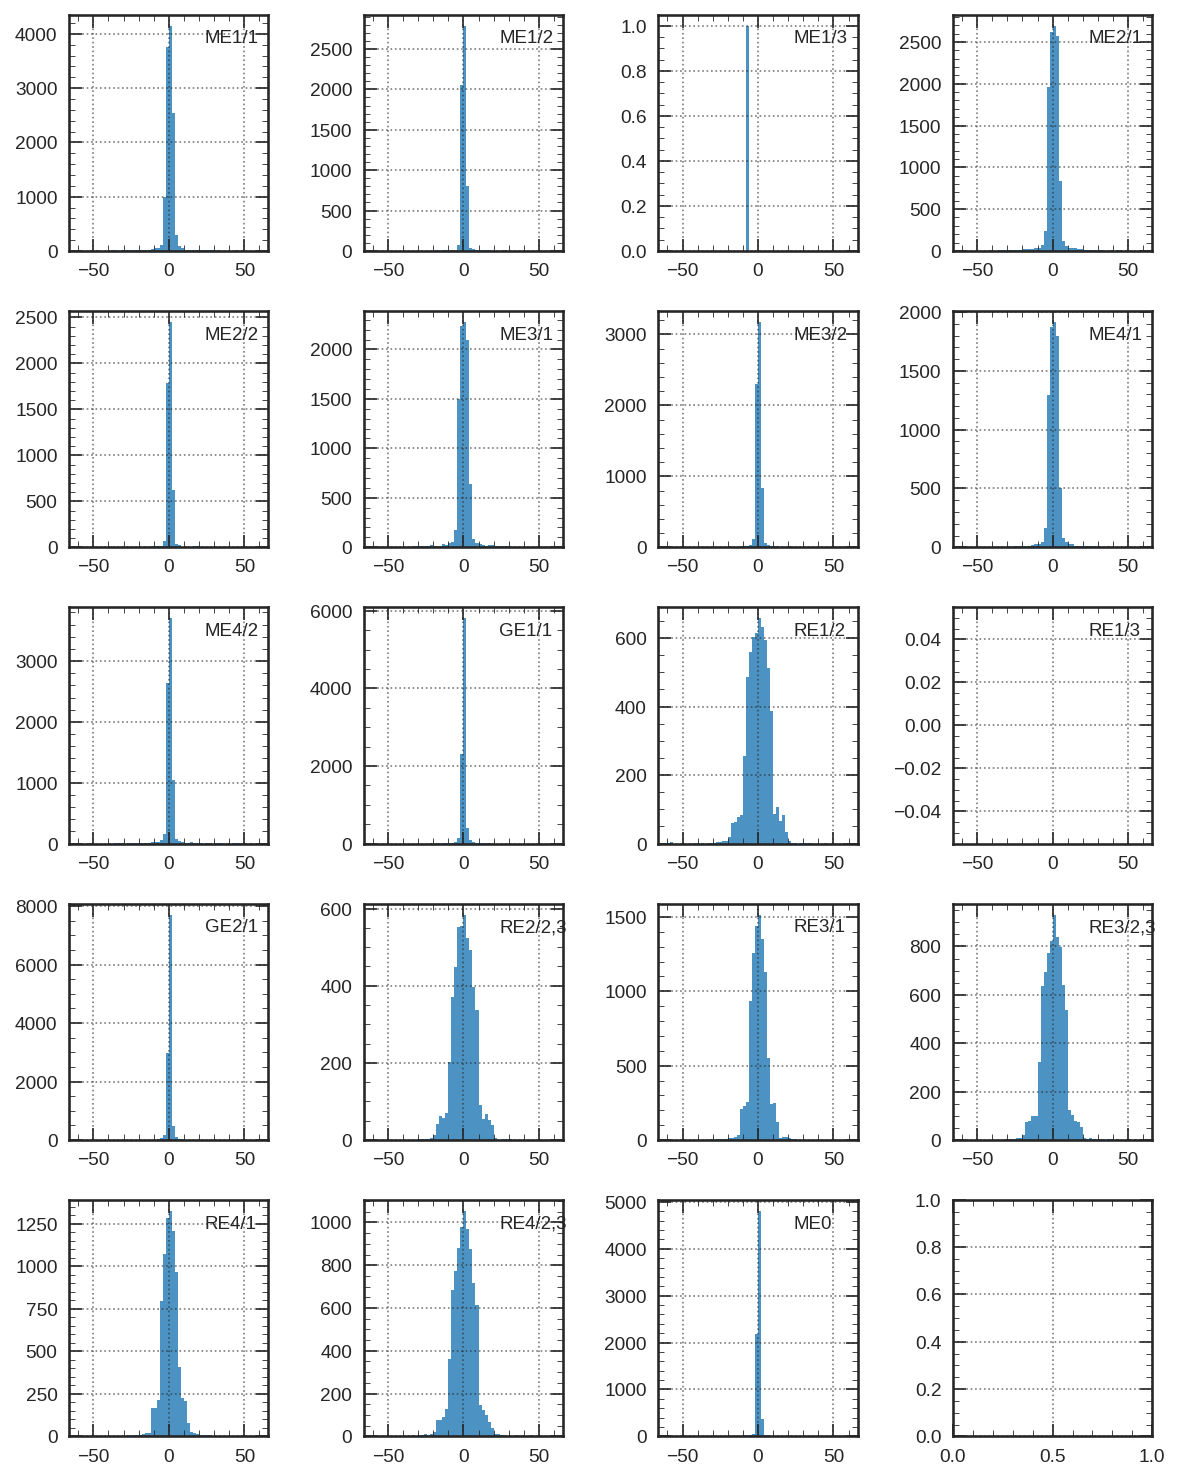

In [10]:
plotter = Plotter(thres=20.)
plotter.plot()

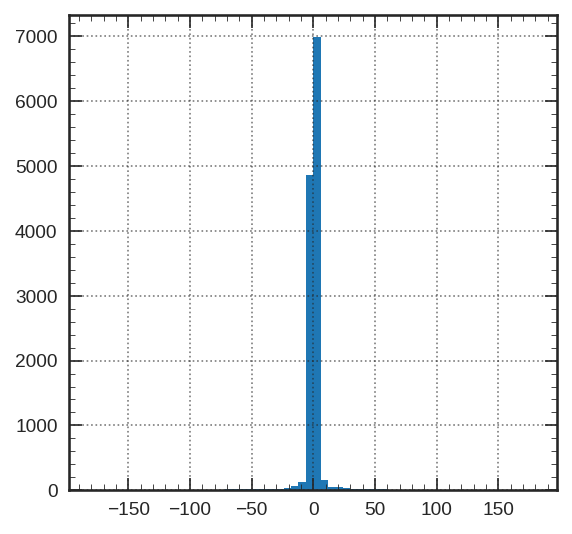

In [11]:
plt.hist(plotter._cache[0], bins=60, range=(-180,180))
plt.show()

In [12]:
class Plotter2(object):
  def __init__(self, thres):
    self._thres = thres  # pt threshold
    assert self._thres >= 0.

    self._cache = np.empty(num_emtf_hosts, dtype=object)
    for k in range(num_emtf_hosts):
      self._cache[k] = []

  def _process(self):
    sel_thres = (part_pt_values > self._thres)

    for i in range(len(sector_hits)):
      if not sel_thres[i]:
        continue

      f1 = sector_hits_fields.emtf_host
      f2 = sector_hits_fields.emtf_phi

      d_sim = collections.defaultdict(list)
      arr = sector_simhits[i]
      for k, v in zip(arr[:, f1], arr[:, f2]):
        d_sim[k].append(v)

      d = collections.defaultdict(list)
      arr = sector_hits[i]
      for k, v in zip(arr[:, f1], arr[:, f2]):
        d[k].append(v)

      # Count num of hits without a matching simhit
      for k in d.keys():
        if k not in d_sim:
          self._cache[k].append(1)

    for k in range(num_emtf_hosts):
      self._cache[k] = np.asarray(self._cache[k], dtype=np.int32)

  def plot(self):
    self._process()

    fig, axs = plt.subplots(5, 4, figsize=(8, 8*5/4), tight_layout=True)
    for ij in range(num_emtf_hosts):
      i, j = (ij // 4, ij % 4)
      ax = axs[i, j]
      ax.hist(self._cache[ij], color='C0', histtype='stepfilled', alpha=0.8)
      ax.text(0.68, 0.88, emtf_host_labels[ij], fontsize=9, transform=ax.transAxes)

    plt.show()

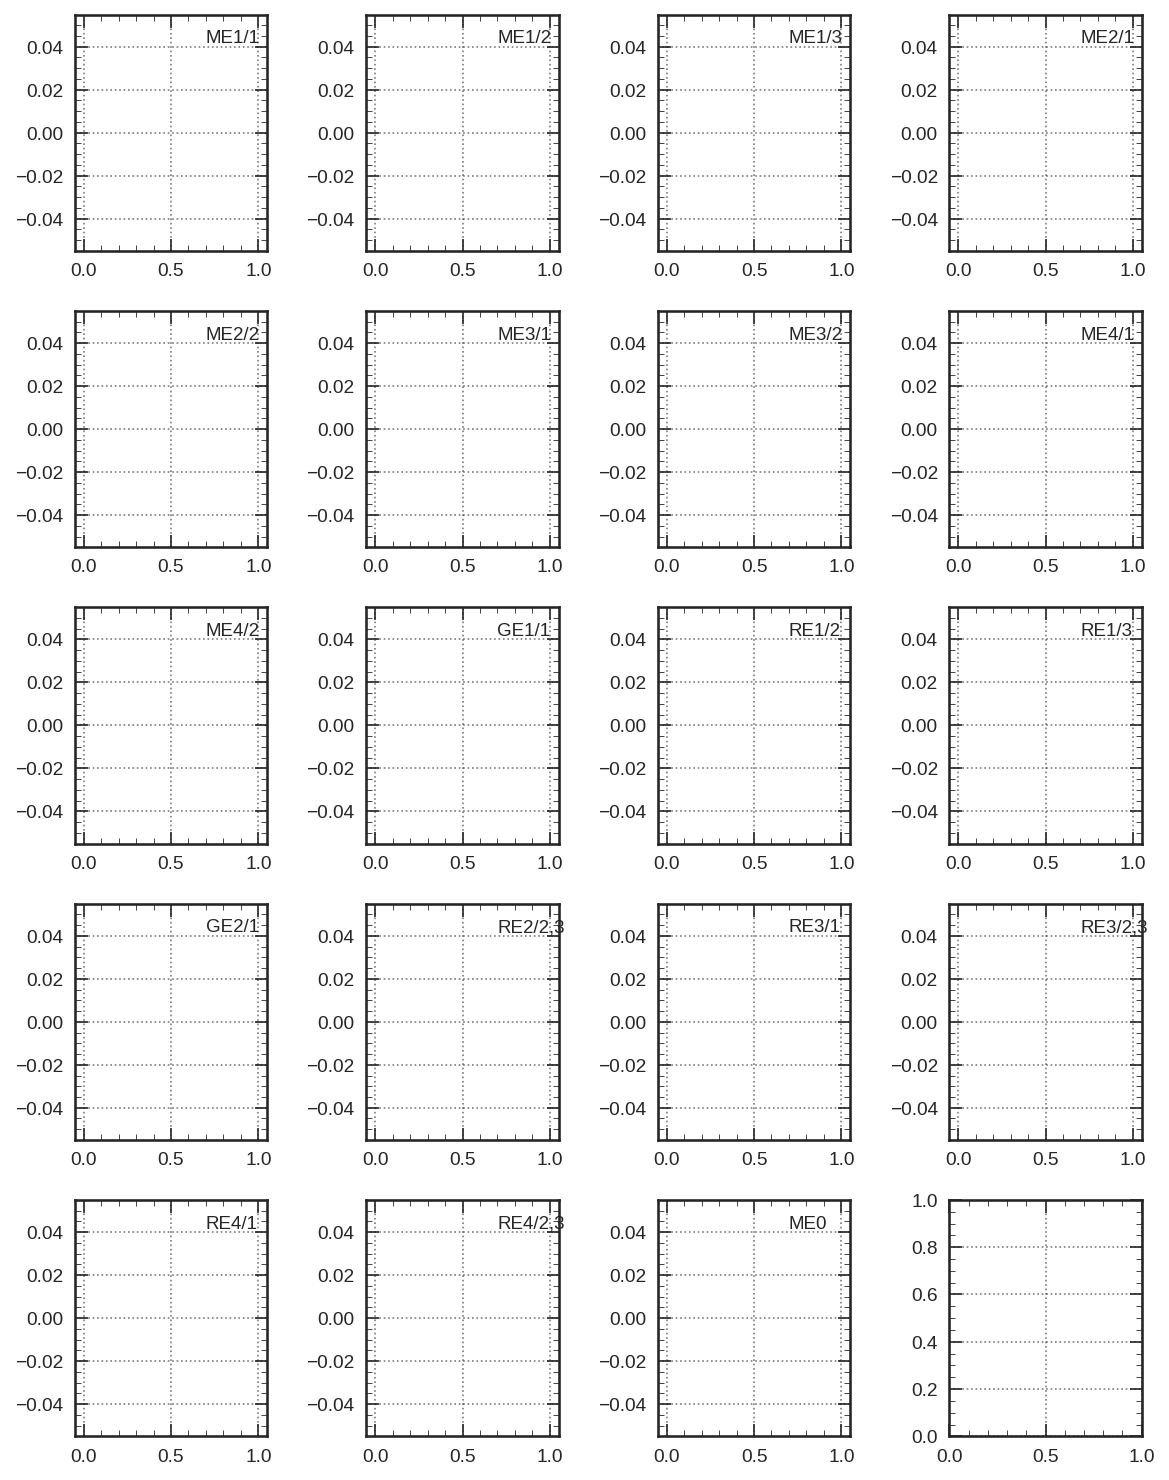

In [13]:
plotter2 = Plotter2(thres=2.)
plotter2.plot()

In [14]:
class Plotter3(object):
  def __init__(self, thres):
    self._thres = thres  # pt threshold
    assert self._thres >= 0.

    self._cache = np.empty(num_emtf_hosts, dtype=object)
    for k in range(num_emtf_hosts):
      self._cache[k] = []

  def _process(self):
    sel_thres = (part_pt_values > self._thres)

    for i in range(len(sector_hits)):
      if not sel_thres[i]:
        continue

      f1 = sector_hits_fields.emtf_host
      f2 = sector_hits_fields.emtf_phi

      d = collections.defaultdict(list)
      arr = sector_hits[i]
      for k, v in zip(arr[:, f1], arr[:, f2]):
        d[k].append(v)

      # Count num of hits
      for k in d.keys():
        cnt = len(d[k])
        self._cache[k].append(cnt)

    for k in range(num_emtf_hosts):
      self._cache[k] = np.asarray(self._cache[k], dtype=np.int32)

  def plot(self):
    self._process()

    fig, axs = plt.subplots(5, 4, figsize=(8, 8*5/4), tight_layout=True)
    for ij in range(num_emtf_hosts):
      i, j = (ij // 4, ij % 4)
      ax = axs[i, j]
      ax.hist(self._cache[ij], bins=10, range=(0,10), color='C0', histtype='stepfilled', alpha=0.8)
      ax.text(0.68, 0.88, emtf_host_labels[ij], fontsize=9, transform=ax.transAxes)

    plt.show()

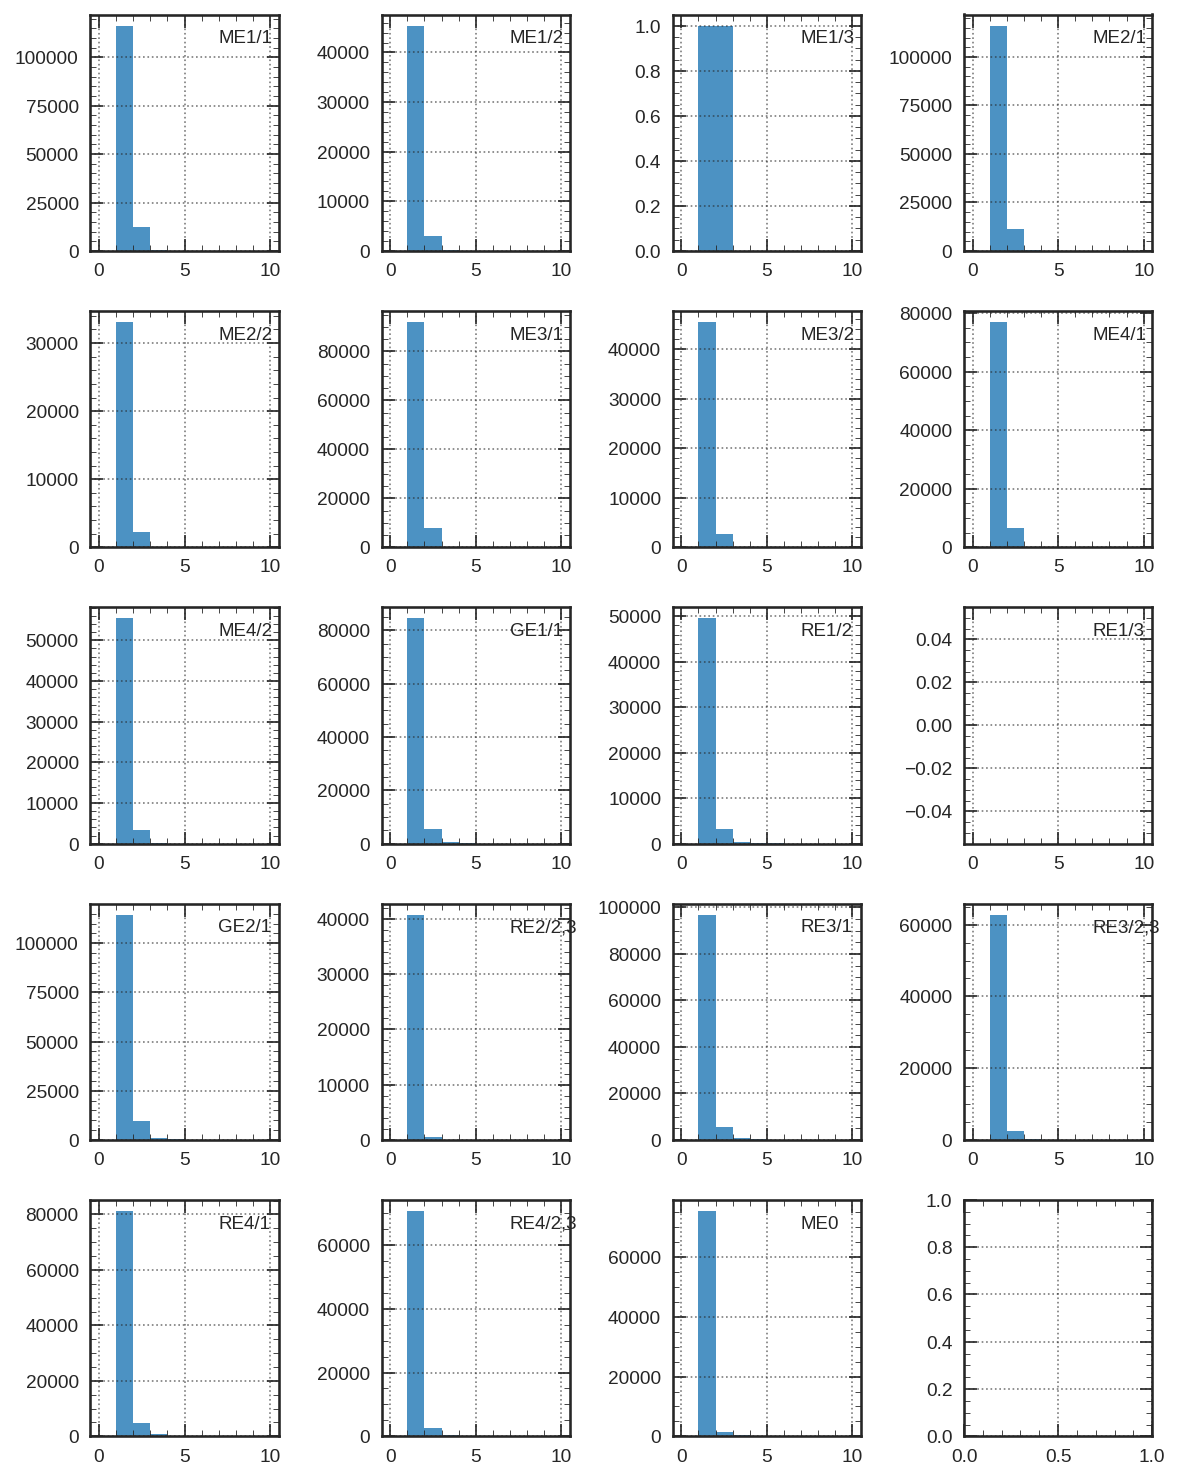

In [15]:
plotter3 = Plotter3(thres=2.)
plotter3.plot()